In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow import keras


number_of_food = 0
food_img_files = []

#==================================================================================================================#
#파일 위치에서 이미지 받아오기

image_dir = Path('../images')

#==================================================================================================================#
#이미지 폴더를 나눠서 판다스 데이터프레임으로 저장

filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

#==================================================================================================================#
#저장한 이미지 정보 확인(판다스 데이터프레임)

food_img_files = sorted(image_df['Label'].unique()).copy()
print(food_img_files)
number_of_food = len(food_img_files)

#==================================================================================================================#
#불러온 이미지 파일들을 학습시킬 데이터와 학습 한 모델을 테스트 할 데이터로 나누기

image_df['Label'].value_counts()
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

#==================================================================================================================#
#텐서플로우 모델에 맞게 이미지 파일을 변환(mobilenet v2)

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

#==================================================================================================================#
#사전 학습된 모델을 선언

pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

#==================================================================================================================#

"""
inputs = keras.Input(shape=(224, 224, 3))

x = pretrained_model(inputs, training=False)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
#outputs = tf.keras.layers.Dense(107, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


print(model.summary())
"""

#==================================================================================================================#
#학습 할 모델의 input 과 output 데이터를 정의
#input class 의 개수는 number_of_food개 (이미지 -> 음식이 number_of_food종류가 있기 떄문임)
#이후 모델을 선언하고, input과 output을 파라미터로 넣기.

inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(number_of_food, activation='softmax')(x)
#outputs = tf.keras.layers.Dense(107, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)


#print(model.summary()) #-> 모델 요약 - 보고 싶으면 주석처리 지우기

#==================================================================================================================#
#모델을 학습시기키 전에, 학습 한 모델의 파일이 저장될 위치를 지정
#model.fit()을 실행시키기 전에, 모델의 가중치를 저장 할 콜백 체크포인트를 지정

checkpoint_path = "../backend/7_foods.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#==================================================================================================================#

['almond', 'boiled egg', 'chicken_breast', 'fried egg', 'multigrain rice', 'pork', 'sweetpotato', 'tomato', 'white rice']
Found 504 validated image filenames belonging to 9 classes.
Found 126 validated image filenames belonging to 9 classes.
Found 270 validated image filenames belonging to 9 classes.


In [39]:
#==================================================================================================================#
#모델 학습

num = 150 #학습시킬 횟수

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=num,
    callbacks=[cp_callback]
)

#==================================================================================================================#
#모델이 잘 있는지 확인
os.listdir(checkpoint_dir)

#==================================================================================================================#
#학습한 모델의 정확성을 확인

results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))


c:\Users\choi0\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 626ms/step - accuracy: 0.2493 - loss: 2.0442
Epoch 1: saving model to ../backend/7_foods.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.2578 - loss: 2.0284 - val_accuracy: 0.4762 - val_loss: 1.4182
Epoch 2/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - accuracy: 0.7199 - loss: 0.8618
Epoch 2: saving model to ../backend/7_foods.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 721ms/step - accuracy: 0.7220 - loss: 0.8569 - val_accuracy: 0.6270 - val_loss: 0.9811
Epoch 3/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.8745 - loss: 0.4519
Epoch 3: saving model to ../backend/7_foods.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 840ms/step - accuracy: 0.8752 - loss: 0.4501 - val_accuracy: 0.7063 - val_loss: 0.8391
Epoch 4/150
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 651ms/step - accuracy: 0.9786 - loss: 0.1921
Epoch 4: saving model to ../backend/7_foods.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 889ms/step - accuracy: 0.9782 - loss: 0.1925 - val

저장된 가중치를 불러와서 정상작동하는지 확인하는코드

In [40]:
#==================================================================================================================#
def create_model ():
    pretrained_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(number_of_food, activation='softmax')(x)
    #outputs = tf.keras.layers.Dense(107, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model
    
#==================================================================================================================#

# Loads the weights
checkpoint_path = "../backend/7_foods.weights.h5"
model = create_model()
model.load_weights(checkpoint_path)
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# Re-evaluate the model
results = model.evaluate(test_images, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

c:\Users\choi0\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test Accuracy: 77.78%
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 683ms/step


거의 최종 가중치 불러오기 코드

In [41]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report

# 클래스 이름 리스트 (예: ["Pizza", "Burger", "Salad", "Sushi"])
#class_names = ["삶은계란", "닭가슴살", "계란후라이", "볶음밥", "잡곡밥", "돼지고기", "백미밥"] # -> 음식 인덱스

food_df = pd.read_csv("../backend/food_df.csv")
class_names = list(food_df["food_name"])

def create_model ():
    """_summary_
    학습된 가중치를 불러오기 전, 가중치를 집어 넣을 모델을 선언\n
        예시 : new model = create_model()
    Returns:
        _type_: tf.keras.Model(inputs, outputs)\n
        케라스 mobilnet_v2 모델
    """
    pretrained_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    pretrained_model.trainable = False

    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(number_of_food, activation='softmax')(x)
    #outputs = tf.keras.layers.Dense(107, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# 사전 학습된 MobileNet V2 모델 로드
# `model_path`는 학습된 모델의 저장 경로입니다.
checkpoint_path = "../backend/7_foods.weights.h5"
model_path = checkpoint_path  # 예시 경로
model = create_model()
model.load_weights(checkpoint_path)

def preprocess_image(image_path):
    """
    이미지를 전처리하여 모델에 입력할 수 있는 형태로 변환합니다.
    """
    image = Image.open(image_path).resize((224, 224))  # 크기 조정
    image = np.array(image)  # numpy 배열로 변환
    image = preprocess_input(image)  # MobileNet V2 전처리 적용
    image = np.expand_dims(image, axis=0)  # 배치 차원 추가
    return image

def predict_food(image_path):
    """
    이미지 경로를 받아서 예측된 음식 이름을 반환합니다.
    """
    # 이미지 전처리
    processed_image = preprocess_image(image_path)
    
    # 예측 수행
    predictions = model.predict(processed_image)
    class_idx = np.argmax(predictions)  # 가장 높은 확률의 클래스 인덱스
    
    return class_idx

# 예제 실행
if __name__ == "__main__":
    
    아몬드 = "../images/almond/almond (10).jpg"
    삶은계란 = "../images/boiled egg/다운로드 (17).jpg"
    닭가슴살 = "../images/chicken_breast/다운로드 (6).jpg"
    계란후라이 = "../images/fried egg/다운로드 (16).jpg"
    잡곡밥 = "../images/Multigrain rice/다운로드 (16).jpg"
    돼지고기 = "../images/pork/images - 2025-03-28T111141.519.jpg"
    고구마 = "../images/sweetpotato/sweetpotato (200).jpg"
    토마토 = "../images/tomato/tomato (40).jpg"
    백미밥 = "../images/white rice/다운로드 (4).jpg"
    
    
    image_path = 돼지고기  # 테스트 이미지 경로
    predicted_food = predict_food(image_path)
    print(predicted_food)
    print(f"예측된 음식: {class_names[predicted_food]}")
    

c:\Users\choi0\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
5
예측된 음식: pork


모델의 성능을 시각화

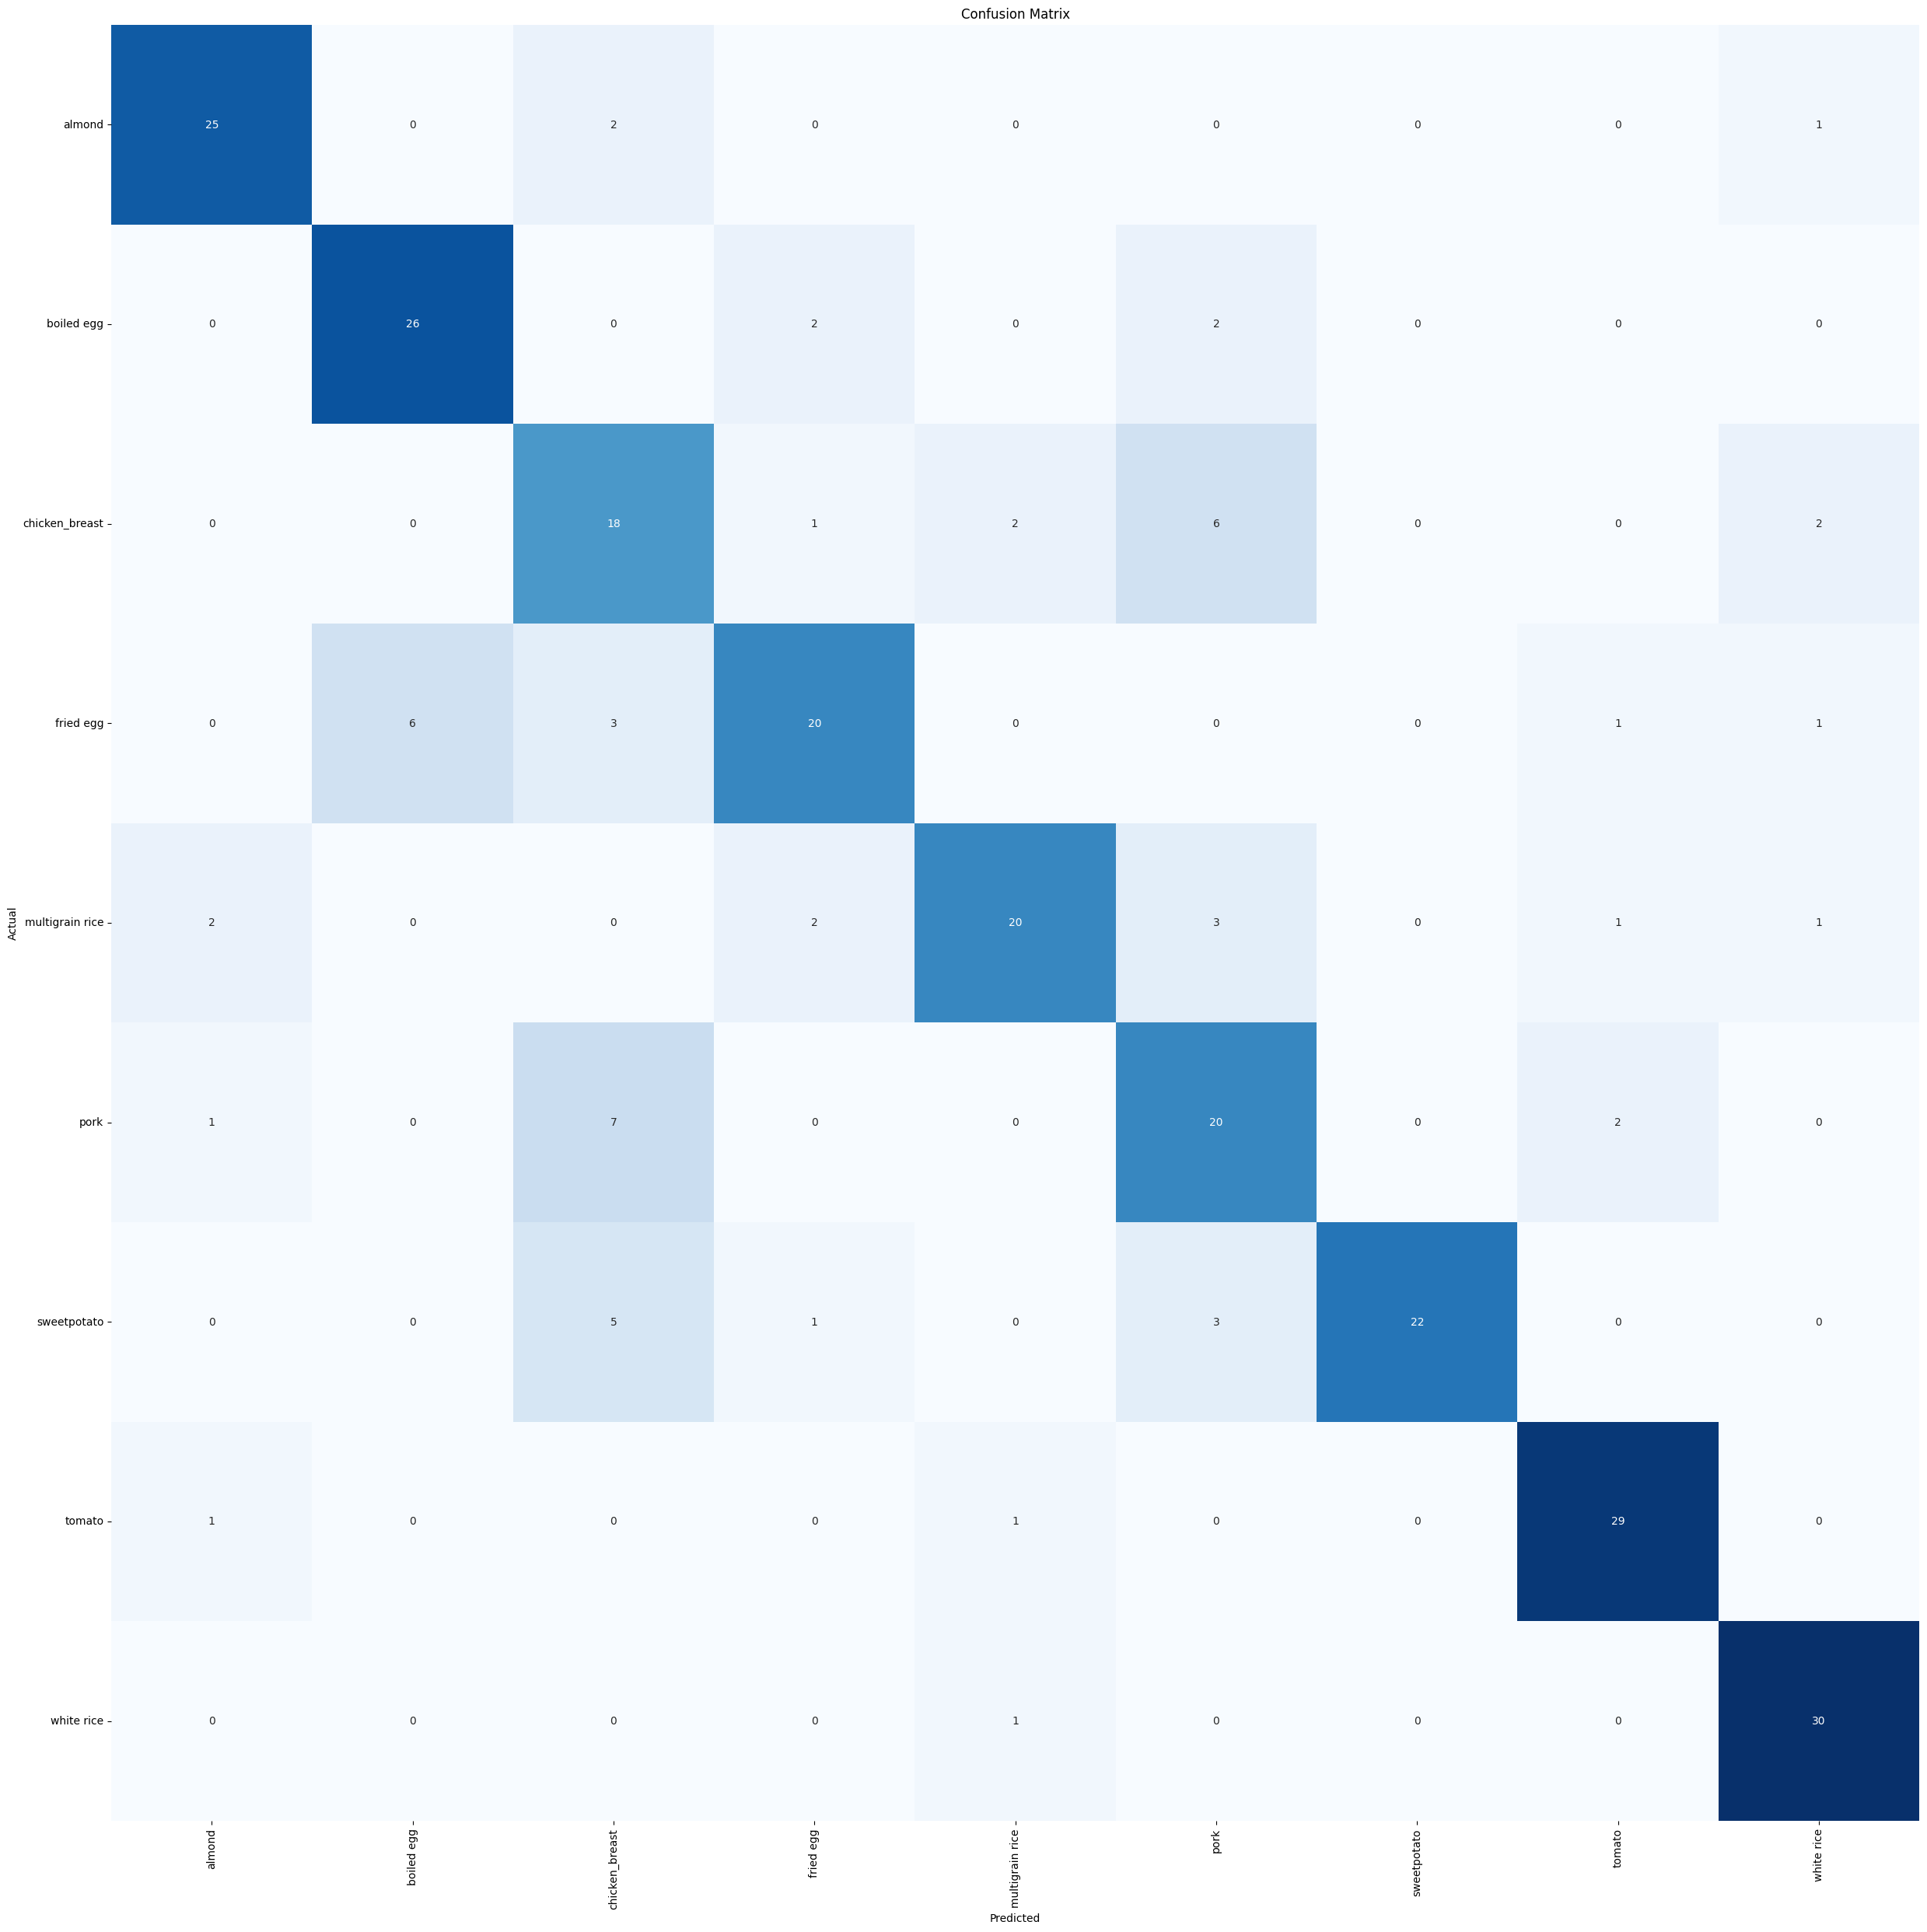

In [42]:
plt.figure(figsize=(30, 30))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(number_of_food) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(number_of_food) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [43]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                  precision    recall  f1-score   support

         almond       0.86      0.89      0.88        28
     boiled egg       0.81      0.87      0.84        30
 chicken_breast       0.51      0.62      0.56        29
      fried egg       0.77      0.65      0.70        31
multigrain rice       0.83      0.69      0.75        29
           pork       0.59      0.67      0.62        30
    sweetpotato       1.00      0.71      0.83        31
         tomato       0.88      0.94      0.91        31
     white rice       0.86      0.97      0.91        31

       accuracy                           0.78       270
      macro avg       0.79      0.78      0.78       270
   weighted avg       0.79      0.78      0.78       270

